<img src=../images/generic.png width=1200 margin=0px>

---


# UCB-1 Setting up Boundary

## Business Value of Capability
 * Configure the instance of boundary with a simple postgres SQL backend. 

### Prerequisites
*  Postgres Container. A Boundary container, or start up you instance locally.

<img src=attachment:image.png width=1000>
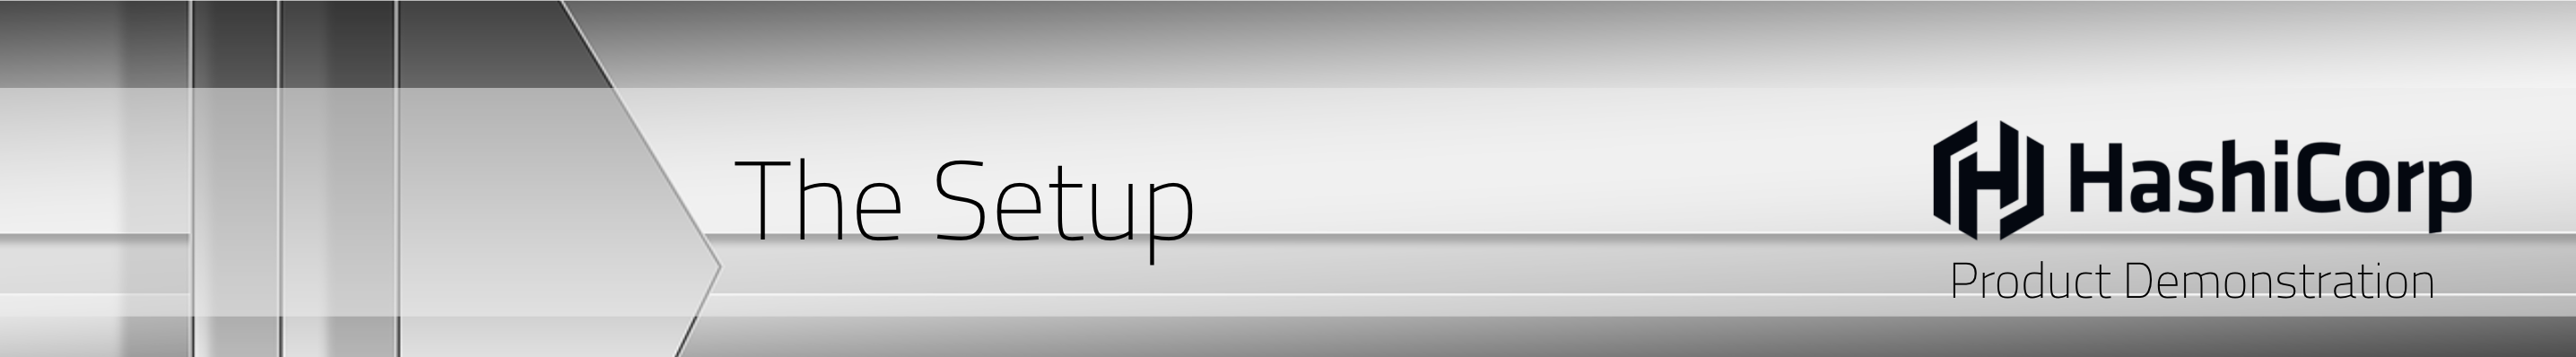

In [ ]:
boundary -version

In [ ]:
## get an image of Boundary and postgres
docker pull hashicorp/boundary
docker pull postgres

In [ ]:
## ENV VARS for postres
export PG_USER=username
export PG_PWD=password
export PG_DB=boundarydb
export BOUNDARY_POSTGRES_URL="postgresql://${PG_USER}:$PG_PWD@pg:5432/$PG_DB?sslmode=disable"

In [ ]:
env | grep BOUNDARY_POSTGRES_URL

In [ ]:
## we will set up a bridge network inside docker for them to talk. 
docker network create bbridge --driver bridge

In [ ]:
## use a simple postgres instance as a backend
## Setup docker container
docker create \
  --name PostgresDB \
  --network bbridge \
  -h pg \
  -p 5432:5432 \
  -e POSTGRES_DB=$PG_DB \
  -e POSTGRES_USER=$PG_USER \
  -e POSTGRES_PASSWORD=$PG_PWD \
  postgres

In [ ]:
# start up postgres - need it running for the initialization
docker start PostgresDB

In [ ]:
## to initialize tables for boundary
docker run \
  --name initializer \
  --network bbridge \
  -e BOUNDARY_POSTGRES_URL=$BOUNDARY_POSTGRES_URL \
  hashicorp/boundary database init -config /boundary/config.hcl

In [ ]:
## remove docker instance used to initialize postgres db 
docker rm initializer

In [ ]:
## double check working directory to ensure it + config gives hcl file
ls $(pwd)/config

In [ ]:
## Create the boundary instance 
## IF YOU WANT TO START BOUNDARY WITH DEFAULT CONFIG IN THE CONTAINER THEN
## REMOVE the -v (volume) configuration . It will still work. 
docker create \
  --name BoundarySvr \
  --network bbridge \
  -h boundary \
  -p 9200:9200 \
  -p 9201:9201 \
  -p 9202:9202 \
  -v "$(pwd)/config/":/boundary/ \
  -e BOUNDARY_POSTGRES_URL=$BOUNDARY_POSTGRES_URL \
  hashicorp/boundary

In [ ]:
## start the boundary servr
docker start BoundarySvr

### You should be able to access the admin console at : http://127.0.0.1:9200

---
### <span style="background-color: #001f3f; color: #80bfff; padding: 15px; border-radius: 2px">Stop Boundary</span>

In [ ]:
# Stop all containers
docker stop BoundarySvr
docker stop PostgresDB

In [ ]:
## Cleanup the containers.
docker rm BoundarySvr
docker rm PostgresDB

In [ ]:
boundary --help


In [ ]:
boundary authenticate password \
         -login-name=admin \
         -password password \
         -auth-method-id=ampw_1234567890

In [ ]:
boundary users list